## 1.1 Single camera calibration using DLT and normalization w/ predefined points

This script intends to calibrate a camera using DLT and predefined world and camera points.\
For this implementation we will use the DLT transform for the estimation of the camera parameters.\
**Firstly, we will run the normal DLT without normalization and then with normalization. It is expected to achieve better results with normalization.**



When dealing with an uncalibrated camera, 11 parameters are unknown, meaning we need at least **6 points** and assume the model of the camera is **affine**.
>**Problem specification:**
- Estimate the 11 elements of P given:
    - 3D coordinates $X_{i}$ of I $\geq$ 6 object points


<img src="/home/alegria/calibration/images/camera_orientation.png" width=400 height=400 />\


## Import the libraries

In [58]:
#%matplotlib qt
#%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

## Generate world and image points

In [59]:
xyz = [[-875, 0, 9.755], [442, 0, 9.755], [1921, 0, 9.755], [2951, 0.5, 9.755], [-4132, 0.5, 23.618],
[-876, 0, 23.618]]
# Known pixel coordinates
uv = [[76, 706], [702, 706], [1440, 706], [1867, 706], [264, 523], [625, 523]]

xyz = np.array(xyz)
uv = np.array(uv)

I_pts = uv


n = (xyz.shape[0])


world_pts_list = []
image_pts_list = []

world_pts = np.zeros((n,4))
image_pts = np.zeros((n,3))

print(world_pts.shape)
for i in range(n):
    world_pts[i,:] = ([xyz[i,0],xyz[i,1],xyz[i,2],1])
    image_pts[i,:] = ([uv[i,0],uv[i,1],1])



(6, 4)


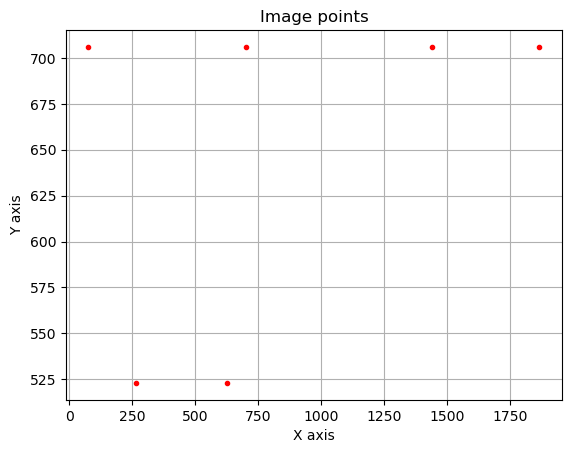

In [60]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".")
ax.set_title("Image points")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
plt.show()

## Direct Linear Transform(DLT)

In [61]:
# get the shape of the matrix
worldm, worldn = world_pts.shape
imagem, imagen = image_pts.shape


In [62]:
#3D DLT
A = []

for i in range(worldm):
    A = np.append(A,[world_pts[i,0],world_pts[i,1],world_pts[i,2],world_pts[i,3],0,0,0,0,-image_pts[i,0]*world_pts[i,0],-image_pts[i,0]*world_pts[i,1],-image_pts[i,0]*world_pts[i,2],-image_pts[i,0]])
    A = np.append(A,[0,0,0,0,world_pts[i,0],world_pts[i,1],world_pts[i,2],world_pts[i,3],-image_pts[i,1]*world_pts[i,0],-image_pts[i,1]*world_pts[i,1],-image_pts[i,1]*world_pts[i,2],-image_pts[i,1]])

# pass the list A as an array
A = np.asarray(A).reshape(n*2,12)
#print(A)
print(A.shape)

(12, 12)


## SVD(Singular Value Decomposition)
Solving a system of linear equations of the form Ax = 0 is equivalent to finding the null space of A. Thus, we can apply the SVD to solve Mp = 0 

### Q.M = 0

**Minimal solution**
- $Q_{(2n×12)}$ should have rank 11 to have a unique (up to a scale) non-zero solution 𝑀
- Because each 3D-to-2D point correspondence provides 2 independent equations, then 5+1/2 point correspondences are needed (in practice 6 point correspondences!)

**Over-determined solution**
- For 𝑛 ≥ 6 points, a solution is the Least Square solution, which minimizes the sum of squared residuals, | 𝑄𝑀 |2, subject to the constraint | 𝑀 |2 = 1.It can be solved through Singular Value Decomposition (SVD). The solution is the eigenvector corresponding to the smallest eigenvalue of the matrix $Q^TQ$(because it is the unit vector 𝑥 that minimizes $\|{Qx}\| = x^TQ^TQx$


In [63]:
# SVD 
U, S, Vh = np.linalg.svd(A)

L = Vh[-1,:] / Vh[-1,-1]
#Camera projection matrix:
PEst = L.reshape(3,3+1)
print("Camera Matrix:\n",PEst)

Camera Matrix:
 [[-2.80108315e-01  2.49378003e+02 -1.26179092e+02  9.39844658e+02]
 [ 7.23778565e-03  4.71324605e+01 -7.75597415e+01  3.36192158e+02]
 [ 1.02518211e-05  6.67598590e-02 -1.63554264e-01  1.00000000e+00]]


### Predicted/Expected value

In [64]:
xEst = np.zeros((worldm,3))
for j in range(worldm):
    xEst[j,:]  = np.dot(PEst,world_pts[j])
    xEst[j,:] /= xEst[j,2]


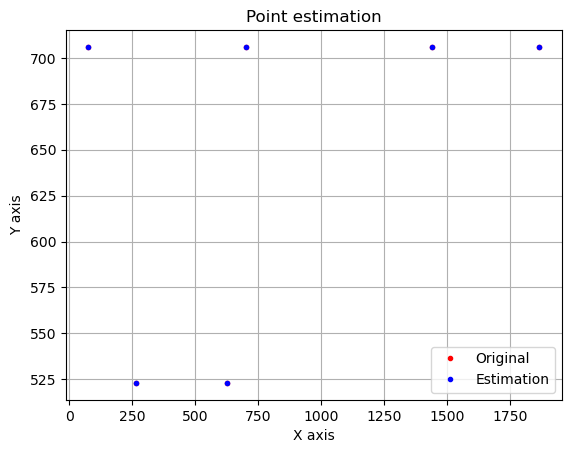

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(xEst[:,0],xEst[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

## Geometric Error

$$E = \sum{d(x_i, MX_i)}$$
>d is the distance metric( euclidean distance)

In [66]:
err = np.sqrt(np.mean(np.sum(np.square(I_pts-xEst[:,:2]), 1)))
print("Geometric error:",err)


#cv2.SOLVEPNP_ITERATIVE()

Geometric error: 9.02842273191844e-08


## Normalization
In order to improve the estimation, it is essential for DLT to normalize the data sample, as follows:
1. The points are tranlated so that their centroid is at the origin
2. The points are scaled so that the average distance from the origin is equal to $\sqrt{2}$
3. This transformation is applied to each of the two images independently

> Data normalization is an essential step in DLT. It must not be considered optional. - *Harley*

**Algorithm:**
- Normalization of X
- Normalization of x 
- DLT
- Denormalization

In [67]:

def normalization(data, dim):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).
    Inputs:
    data: the data to be normalized (directions at different columns and points at rows)
    Outputs:
    T : the transformation matrix (translation plus scaling)
    '''

    N = data.shape[0]
    
    if dim == 2:                                                     # 2D points
        x, y = data[:, 0], data[:, 1]                               # x and y coordinates
        x_mean, y_mean = x.mean(), y.mean()                         # mean 
        x_par = (x-x_mean)**2                                       # x part
        y_par = (y-y_mean)**2                                       # y part

        d = (1/N)* np.sum(np.sqrt(x_par + y_par))                   # d
        s_xy = np.sqrt(2)/d                                         # sqrt(2)/d

        T = np.zeros((3,3))                                         # normalization matrix for 2D points
        T[0,0] = s_xy
        T[0,2] = -x_mean*s_xy
        T[1,1] = s_xy
        T[1,2] = -y_mean*s_xy
        T[-1,-1] = 1

    elif(dim== 3):                                                  # 3D points
        X, Y, Z = data[:, 0], data[:, 1], data[:,2]                 # x and y coordinates
        X_mean, Y_mean,Z_mean = X.mean(), Y.mean(),Z.mean()         # mean 
        X_par = (X-X_mean)**2                                       # x part
        Y_par = (Y-Y_mean)**2                                       # y part
        Z_par = (Z-Z_mean)**2                                       # z part

        D = (1/N)* np.sum(np.sqrt(X_par + Y_par + Z_par))           # d
        s_xyz = np.sqrt(3)/D                                        # sqrt(2)/d

        T = np.zeros((4,4))                                         # normalization matrix for 3D points
        T[0,0] = s_xyz
        T[0,3] = -X_mean*s_xyz
        T[1,1] = s_xyz
        T[1,3] = -Y_mean*s_xyz
        T[2,2] = s_xyz
        T[2,3] = -Z_mean*s_xyz
        T[-1,-1] = 1
    else:
        raise ValueError('Dataset must be a collection of 2D or points')

    return T


In [68]:
Txy = normalization(image_pts,2)
#print("Normalization matrix for 2D:\n",T_matrix)
Txyz = normalization(world_pts,3)
#print("Normalization matrix for 3D :\n",U_matrix)

#normalized imagecoordinates
xyn = np.dot(image_pts,Txy.T)
#normalized worldcoordinates
xyzn = np.dot(world_pts,Txyz.T)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(xyn[:,0],xyn[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
# ax.set_title("Point estimation")
# ax.set_xlabel("X axis")
# ax.set_ylabel("Y axis")
# ax.grid()
# ax.legend()
# plt.show()

For each image A generates a (2,12)

In [69]:
#3D DLT
A = []
sz = len(xyzn)

for i in range(sz):
    x, y, z = xyzn[i, 0], xyzn[i, 1], xyzn[i, 2]
    u, v = xyn[i, 0], xyn[i, 1]
    A.append( [-x, -y, -z, -1, 0, 0, 0, 0, u * x, u * y, u * z, u] )
    A.append( [0, 0, 0, 0, -x, -y, -z, -1, v * x, v * y, v * z, v] )

# pass the list A as an array
A = np.asarray(A).reshape(sz*2,12)
#print(A)
print(A.shape)



(12, 12)


In [70]:
# SVD 
U, S, Vh = np.linalg.svd(A)
L = Vh[-1,:] / Vh[-1,-1]
print(Vh[-1,:])
# Camera projection matrix
H_norm = L.reshape(3, 3 + 1)
print(H_norm)


[-1.38463409e-03  9.30906496e-01  4.51333247e-02  1.36164193e-03
  3.00026005e-06  1.95376934e-02  1.34011440e-01  4.15771759e-04
  1.95103266e-05  1.27051247e-01 -3.11261490e-01 -2.36881555e-03]
[[ 5.84525921e-01 -3.92983952e+02 -1.90531190e+01 -5.74819737e-01]
 [-1.26656550e-03 -8.24787452e+00 -5.65731850e+01 -1.75518841e-01]
 [-8.23632155e-03 -5.36349259e+01  1.31399631e+02  1.00000000e+00]]


## Denormalization

In [71]:
# Denormalize the coordinates
H = np.linalg.pinv(Txy).dot((H_norm).dot(Txyz))
print(H)
H = H / H[-1, -2]
print(H)
print(H.shape)

[[ 2.08864341e-01 -1.85950110e+02  9.40861494e+01 -7.00800455e+02]
 [-5.39689559e-03 -3.51445841e+01  5.78328574e+01 -2.50683573e+02]
 [-7.64432802e-06 -4.97798641e-02  1.21955157e-01 -7.45655624e-01]]
[[ 1.71263230e+00 -1.52474167e+03  7.71481519e+02 -5.74637822e+03]
 [-4.42531151e-02 -2.88176286e+02  4.74214122e+02 -2.05553894e+03]
 [-6.26814662e-05 -4.08181708e-01  1.00000000e+00 -6.11417873e+00]]
(3, 4)


### Predicted/Expected value

In [72]:

pts_norm = np.zeros((worldm,3))
for j in range(worldm):
    pts_norm[j,:]  = np.dot(H,world_pts[j])
    pts_norm[j,:] /= pts_norm[j,2]


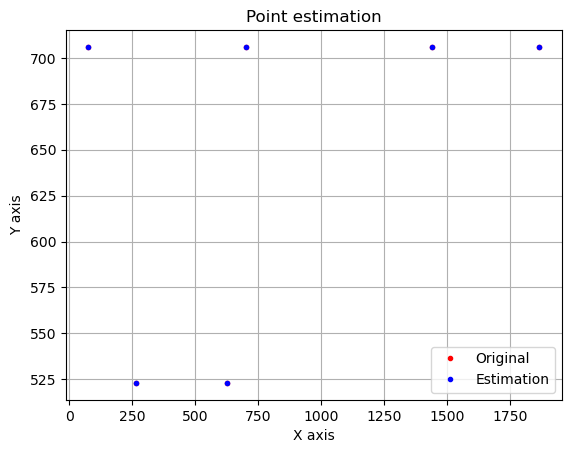

In [73]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(pts_norm[:,0],pts_norm[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

## Geometric Error 
Geometric error essentially gives an estimate of how far the predictions are from the ground truth. It does so by measuring the distance between the predicted projection of a point and its ground truth projection. When we minimize the geometric error, we’re essentially minimizing the distance between the predictions and the ground truth.
$$E = \sum{d(x_i,x'_i)}$$

In [74]:
# Mean distance:
err = np.sqrt(np.mean(np.sum(np.square(I_pts-pts_norm[:,:2]), 1)))
print("Geometric Error after normalization : ",err) 

(6, 3)
Geometric Error after normalization :  1.9717080985759816e-10


We can see in fact that the normalization enhances the performance of the calibration by 100x times.